# Mount drive

In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# FOLDERNAME = 'ex3_302168687_200409159'
sys.path.append('/content/drive/MyDrive')
# sys.path.append('/content/drive/My Drive/{}/Q4'.format(FOLDERNAME))
%cd /content/drive/MyDrive
time_test=True
# %load_ext autoreload
# %autoreload 2

Mounted at /content/drive/
/content/drive/MyDrive


# Imports

In [2]:
!pip install torch # ==1.7.0+cu101
!pip install torchaudio==0.7.0
!pip install torchvision==0.8.0
!pip install soundfile

     |████████████████████████████████| 7.6MB 9.0MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchvision 0.8.2+cu101 has requirement torch==1.7.1, but you'll have torch 1.7.0 which is incompatible.
  Found existing installation: torch 1.7.1+cu101
    Uninstalling torch-1.7.1+cu101:
      Successfully uninstalled torch-1.7.1+cu101
     |████████████████████████████████| 11.8MB 262kB/s 
  Found existing installation: torchvision 0.8.2+cu101
    Uninstalling torchvision-0.8.2+cu101:
      Successfully uninstalled torchvision-0.8.2+cu101


In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, models, transforms
import torchaudio

import os
import matplotlib
import pylab
import librosa
import numpy as np

import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

#!apt-get install sox libsox-dev libsox-fmt-all
#!pip install git+git://github.com/pytorch/audio
from IPython.display import Audio

from scipy.io import wavfile
from librosa.feature import mfcc
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 

import os
import pandas as pd
import random

from pathlib import Path

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# Model architecture


In [4]:
class GuidedBackpropReLU(torch.autograd.Function):
    @staticmethod
    def forward(self, input_img):
        positive_mask = (input_img > 0).type_as(input_img)
        output = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), input_img, positive_mask)
        self.save_for_backward(input_img, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input_img, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input_img > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),
                                   torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input

In [5]:
gbp_relu = GuidedBackpropReLU()

class CnnAudioNet(nn.Module):
    def __init__(self,numClasses):
        super(CnnAudioNet,self).__init__()
        self.num_classes = numClasses
        self.fc_features = 128
        self.C1 = nn.Conv2d(1,32,3,padding=1)
        self.C11 = nn.Conv2d(32,32,3,padding=1)
        self.C2 = nn.Conv2d(32,64,3,padding=1)
        self.C22 = nn.Conv2d(64,64,3,padding=1)
        self.C3 = nn.Conv2d(64,128,3,padding=1)
        self.C33 = nn.Conv2d(128,128,3,padding=1)
        
        self.BN1 = nn.BatchNorm2d(32)
        self.BN11 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN22 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN33 = nn.BatchNorm2d(128)
        
        self.BNFC = nn.BatchNorm1d(self.fc_features)

        self.maxpool_1 = nn.MaxPool2d(2,2)
        self.maxpool_2 = nn.MaxPool2d(2,2)
        self.maxpool_3 = nn.MaxPool2d(2,2)
        self.maxpool_4 = nn.MaxPool2d(2,2)
        self.maxpool_5 = nn.MaxPool2d(2,2)
        self.maxpool_6 = nn.MaxPool2d(2,2)

        self.softmax = nn.Softmax(dim=1)
        
        self.flatten = torch.nn.Flatten()

        # self.fc1 = nn.Linear(64*32*32,self.fc_features)
        self.fc1 = nn.Linear(512,self.fc_features)
        self.fc2 = nn.Linear(self.fc_features, 1) 
        
        self.dropout = nn.Dropout(0.35)

        self.BNout = nn.BatchNorm1d(1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.activations_1 = nn.ReLU() # gbp_relu.apply # nn.ReLU()
        self.activations_2 = nn.ReLU() #gbp_relu.apply # nn.ReLU()
        self.activations_3 = nn.ReLU() #gbp_relu.apply # nn.ReLU()
        self.activations_4 = nn.ReLU() #gbp_relu.apply # nn.ReLU()
        self.activations_5 = nn.ReLU() #gbp_relu.apply # nn.ReLU()
        self.activations_6 = nn.ReLU() #gbp_relu.apply # nn.ReLU()

    def forward(self,x,extra_feature):
        # add sequence of convolutional and max pooling layers
        x = self.maxpool_1(self.activations_1(self.BN1(self.C1(x))))
        x = self.maxpool_2(self.activations_2(self.BN11(self.C11(x)))) ##
        x = self.dropout(x)                                 ## @@
        x = self.maxpool_3(self.activations_3(self.BN2(self.C2(x))))     
        x = self.maxpool_4(self.activations_4(self.BN22(self.C22(x)))) ##
        # x = F.relu(self.BN3(self.C3(x)))                  ##
        # x = self.dropout(x)                                 ## @@  
        x = self.maxpool_5(self.activations_5(self.BN3(self.C3(x))))     ## @@
        x = self.maxpool_6(self.activations_6(self.BN33(self.C33(x)))) ##

        # flatten image input
        # x = x.view(-1,64*32*32)
        x = self.flatten(x)

        x = self.BNFC(self.fc1(x))
        x = self.dropout(x)
        if not time_test:
          x = torch.cat((x, extra_feature/240), 1) #normalize extra_feature
          x = self.fc2(x)
        else:
          # x = torch.cat((x, (extra_feature-2)/100), 1) #normalize extra_feature
          x = self.fc2(x)
          x = self.BNout(x)
          x = self.sigmoid(x) * 1440
          # x = (1+self.tanh(x))/2*1440
        #x = self.softmax(x) #already included in CrossEntropyLoss
        return x
        

# Utility functions

In [6]:
from tqdm.auto import tqdm

def plotData(S, sr=44100, hop_length=512):
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    plt.colorbar(format='%+2.0f dB');

def saveDataAsImage(S, save_path):
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
    pylab.close()

def loadRec(wavPath):
    sound, sample_rate = torchaudio.load(wavPath)
    print("sample_rate", sample_rate)
    return Audio(data=sound[0,:],rate=sample_rate) # load a local WAV file

def saveModel(model, model_name, path):
    path = F"{path}/{model_name}.pt"
    torch.save(model.state_dict(), path)

def loadModel(model, model_name, path):
    path = F"{path}/{model_name}.pt"
    if torch.cuda.is_available(): 
      map_location = None
    else:
      map_location = map_location=torch.device('cpu')
    state_dict = torch.load(path, map_location=map_location)
    model.load_state_dict(state_dict)

    return model

@torch.no_grad()
def calculateTestLoss(model, criterion, test_generator):
    model.eval()
    test_loss = 0
    Label_all = []
    Output_all = []
    for dataBatch,target,timestamp in tqdm(test_generator, total=len(test_generator), leave=True):
        dataBatch, target, timestamp = dataBatch.unsqueeze(1).float().cuda(), target.cuda(), timestamp.unsqueeze(1).cuda()
        output = model(dataBatch, timestamp)
        if not time_test:
          loss = criterion(output,torch.max(target.long(), 1)[1])
        else:
          # loss = min(criterion(output, target), criterion(output-1, target), criterion(output+1, target))
          loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))
        test_loss += loss.item()*dataBatch.size(0)
        Label_all.extend(target.tolist())
        Output_all.extend(output.tolist())

    x = np.abs(np.array(Label_all) - np.array(Output_all))
    y = 1440 - np.abs(np.array(Label_all) - np.array(Output_all))
    accuracy = (np.minimum(x,y)<=240).sum() / len(Label_all)
    # y = 1 - np.abs(np.array(Label_all) - np.array(Output_all))
    # accuracy = (np.minimum(x,y)<=(180/1440)).sum() / len(Label_all)

    return test_loss/len(test_generator), accuracy

# Dataset

In [7]:
class Dataset(data.Dataset):
    def __init__(self, fileNames, locations, dataPath, numClasses):
        'Initialization'

        self.locations = locations
        self.file_names = fileNames
        self.data_path = dataPath
        self.num_classes = numClasses
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_names)

    def __getitem__(self, index):
        'Generates one sample of data'
        file_name = self.file_names[index]
        location = self.locations[index]
        file = os.path.join(self.data_path, str(location), str(file_name))
        Im = torch.load(file)
        label_out = np.zeros(self.num_classes)
        label_out = torch.from_numpy(label_out).float()
        timestamp = file_name.split("_", 1)[1]
        timestamp = int(timestamp.split(".", 1)[0])/1000 # quantization of 30-minutes
        timestamp = torch.tensor(timestamp, dtype=torch.float32)
        #print(timestamp, Im.shape, label)
        if not time_test:
          label = location
          label_out[label-2] = 1
          extra_feature = timestamp
        else:
          label = (int(file_name[-9:-7])*60 + int(file_name[-7:-5])) # /1440
          label_out[0] = label
          extra_feature = location

        return Im, label_out, extra_feature

# Select criterion and optimizer and load model

In [8]:
train_on_gpu=torch.cuda.is_available()
if time_test: 
  num_classes = 1
else:
  num_classes = 10
model = CnnAudioNet(num_classes)
model_name= "MonoCnnAudioNet"
if(train_on_gpu): 
    model.cuda()
print(model)

CnnAudioNet(
  (C1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C33): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN22): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN33): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# Load dataset

In [9]:
create_test_csv = False
if create_test_csv:
  import os, csv
  import pdb

  rootdir =  'Project/Testset/Mono'
  csv_path = 'Testset'

  with open(csv_path+"/test_labels.csv", 'w+', newline='') as f:
    w = csv.writer(f)
    w.writerow(["filename", "label"])
    for root, dirs, files in os.walk(rootdir):
      if len(files) > 0:
        dir_num = root.split('/')[-1]
        for fname in files:
          w.writerow([fname, dir_num])

In [15]:
spots_to_train = range(2,12)

random.seed(3)

# TODO: seperate paths for train/test

path = '/content/drive/MyDrive/Project/Dataset'
path_csv = '/content/drive/MyDrive/project_new/copy/DataSet'
test_path_csv = '/content/drive/MyDrive/project_new/copy/TestSet'
test_path = '/content/drive/MyDrive/Project/Testset'

#Load train data
labels = pd.read_csv(os.path.join(path_csv, "labels.csv"))
test_labels = pd.read_csv(os.path.join(test_path_csv, "labels.csv"))

# labels = pd.concat([labels, test_labels])

# labels = labels[labels['label']==2]

# sample_indexes = [label in spots_to_train for label in labels['label']]
# labels = labels[sample_indexes]

n_samples = len(labels)
train_len = int(n_samples * 0.85)
valid_len = n_samples - train_len

n_t_samples = len(test_labels)
test_len   = n_t_samples

total_list = list(range(n_samples))
train_list = random.sample(total_list, train_len)
total_list = list(set(total_list)^set(train_list))
valid_list = random.sample(total_list, valid_len)

# total_list = list(set(total_list)^set(valid_list))
# test_list = random.sample(total_list, test_len)
test_list = list(range(n_t_samples))

test_data = test_labels.iloc[test_list]
train_data = labels.iloc[train_list]
valid_data = labels.iloc[valid_list]

path = os.path.join(path, "Mono")
test_path = os.path.join(test_path, "Mono")

training_set = Dataset(train_data["filename"].tolist(), train_data["label"].tolist(), path, num_classes)
batch_size = 32
train_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(training_set, **train_params)
#Load validation data
valid_set = Dataset(valid_data["filename"].tolist(), valid_data["label"].tolist(), path, num_classes)
batch_size = 32
valid_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
valid_generator = data.DataLoader(valid_set, **valid_params)
#Load Test data
test_set = Dataset(test_data["filename"].tolist(), test_data["label"].tolist(), test_path, num_classes)
batch_size = 32
test_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}
test_generator = data.DataLoader(test_set, **test_params)

print("Training set contains " + str(train_len) + " samples")
print("Validation set contains " + str(valid_len) + " samples")
print("Test set contains " + str(test_len) + " samples")

# ticks for plots

ytick_locs = [0, 31, 63, 95, 127] 
freq_ticks = [0, 1, 2.7, 7.3, 22]

xtick_locs = [0,100,200]
time_ticks = [0,15,30]

adjusted_extent = [0, 200, 0, 128]

Training set contains 34000 samples
Validation set contains 6000 samples
Test set contains 5000 samples


# Estimate error expected value and std

In [ ]:
%pdb off

# print("\n***Only spot 2 used***\n")

import time
# !pip install tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, gaussian_filter, percentile_filter, zoom

num_classes = 1

epoch_num = 74

checkpoint_path = "/content/drive/MyDrive/project_new/copy/weights/Mono/spot_" + '_'.join(str(spot) for spot in spots_to_train)

model_name = "MonoCnnAudioNet"
model = CnnAudioNet(num_classes)
model = loadModel(model, model_name + "_" + str(epoch_num), checkpoint_path)

if not time_test: 
  criterion = nn.CrossEntropyLoss()
else:
  criterion = nn.MSELoss()

if train_on_gpu: 
  model.cuda()

with torch.no_grad():
  for dataloader in [training_generator, valid_generator, test_generator]:
    errors = None
    for batch_idx, (dataBatch, target, extra_feature) in tqdm(enumerate(dataloader), total=len(dataloader)):

      # move tensors to GPU if CUDA is available
      if train_on_gpu:
        dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
      else:
        dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

      model.eval()
      model.zero_grad()

      output = model(dataBatch, extra_feature)

      # # calculate the batch loss
      # if not time_test:
      #   loss = criterion(output,torch.max(target.long(), 1)[1])
      # else:
      #   loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))

      batch_errors = (output - target).squeeze()
      batch_errors.requires_grad = False
      if errors is None:
        errors = batch_errors
      else:
        errors = torch.cat((errors, batch_errors))

    errors = errors.detach().cpu().numpy()
    # errors = errors[np.abs(errors)<500]

    m = errors.mean()
    v = errors.var()
    s = np.sqrt(v)
    RMSE = np.sqrt(np.mean(errors**2))

    print(m)
    print(v)
    print(s)
    print(RMSE)

    plt.hist(errors, density=True, bins=100)  # density=False would make counts
    plt.ylabel('Probability')
    plt.xlabel('Error')
    plt.grid()
    plt.show()

Automatic pdb calling has been turned OFF


# Grad-CAM

In [ ]:
%pdb on

# print("\n***Only spot 2 used***\n")

import time
# !pip install tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, gaussian_filter, percentile_filter, zoom

num_batches = 4
num_classes = 1
# layers_for_maps = ['maxpool_1', 'maxpool_2', 'maxpool_3', 'maxpool_4', 'maxpool_5', 'maxpool_6']
layers_for_maps = ['C1', 'C11', 'C2', 'C22', 'C3', 'C33']

epoch_num = 74

if train_on_gpu: 
  model.cuda()

checkpoint_path = "/content/drive/MyDrive/project_new/copy/weights/Mono/spot_" + '_'.join(str(spot) for spot in spots_to_train)

model_name = "MonoCnnAudioNet"
model = CnnAudioNet(num_classes)
model = loadModel(model, model_name + "_" + str(epoch_num), checkpoint_path)

if not time_test: 
  criterion = nn.CrossEntropyLoss()
else:
  criterion = nn.MSELoss()

def get_feture_map(name):
    def hook(model, input, output):
        # feature_maps[name] = input[0].detach()
        feature_maps[name] = output.detach()
    return hook

def get_grad_map(name):
    def hook(model, grad_input, grad_output):
        # grad_maps[name] = grad_input[0].detach()
        grad_maps[name] = grad_output[0].detach()
    return hook

for layer in layers_for_maps:
  getattr(model, layer).register_forward_hook(get_feture_map(layer))
  getattr(model, layer).register_backward_hook(get_grad_map(layer))

# layers_for_maps = ['input'] + layers_for_maps

for batch_idx, (dataBatch, target, extra_feature) in enumerate(valid_generator):
  if batch_idx >= num_batches:
    break

  feature_maps  = dict()
  grad_maps     = dict()
  grad_cam_imgs = dict()

  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
  else:
    dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

  model.eval()
  model.zero_grad()

  dataBatch.requires_grad_()

  output = model(dataBatch, extra_feature)

  # calculate the batch loss
  if not time_test:
    loss = criterion(output,torch.max(target.long(), 1)[1])
  else:
    loss = -1 * min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))

  loss.backward()

  # compute grad-cam maps for each layer
  for layer, grads in grad_maps.items():
    channel_weights = grads.mean((-2,-1), keepdims=True)
    grad_cam = (channel_weights * feature_maps[layer]).sum(-3)
    # grad_cam[grad_cam<0] = 0 
    grad_cam_imgs[layer] = grad_cam

  # get input spectrogram saliency map
  input_saliency_maps = dataBatch.grad.data.abs()
  # grad_maps['input']  = input_saliency_maps


  plt.figure(figsize=(32, 32/8))
  for i_map in range(6): # first 8 in batch
      plt.subplot(1, 6, i_map + 1)
      spectrogram = dataBatch[i_map,...].squeeze().detach().cpu()
      plt.imshow(spectrogram, origin='lower', extent = adjusted_extent)
      plt.yticks(ytick_locs,freq_ticks)
      plt.xticks(xtick_locs,time_ticks)
      plt.xlabel('time (sec)')
      plt.ylabel('freq (kHz)')
      # plt.axis("off")
  plt.show()

  print('\n')

  for num_layer, layer in enumerate(layers_for_maps):
      print(f"Grad-CAM maps for layer {num_layer+1}:\n")
      plt.figure(figsize=(32, 32/8))
      for i_sample in range(6):
        grad_cam_img = grad_cam_imgs[layer][i_sample,...].squeeze().cpu().numpy()
        img = zoom(grad_cam_img, 128/grad_cam_img.shape[-1], order=4)
        plt.subplot(1, 6, i_sample + 1)
        plt.imshow(img, cmap='gray', origin='lower', extent = adjusted_extent)
        plt.yticks(ytick_locs,freq_ticks)
        plt.xticks(xtick_locs,time_ticks)
        plt.xlabel('time (sec)')
        plt.ylabel('freq (kHz)')
        # plt.axis("off")
        if num_layer == len(layers_for_maps)-1:
          real_time = target[i_sample].squeeze().item()
          est_time  = output[i_sample].squeeze().item()
          abs_error = min(abs(real_time - est_time), 1440 - abs(real_time - est_time))
          plt.title(f"Real_time = {real_time}\nEstimated time = {est_time:.2f}\nAbs error = {abs_error:.2f}")

      plt.show()

      print('\n')

  print('\n\n')


Output hidden; open in https://colab.research.google.com to view.

# Input saliency maps

In [ ]:
%pdb off

import time
# !pip install tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

epoch_num = 74 # take weights from this checkpoint

num_batches = 4

num_classes = 10

checkpoint_path = "/content/drive/MyDrive/project_new/copy/weights/Mono/spot_" + '_'.join(str(spot) for spot in spots_to_train)

model_name = "MonoCnnAudioNet"
model = CnnAudioNet(num_classes)
model = loadModel(model, model_name + "_" + str(epoch_num), checkpoint_path)

if(train_on_gpu): 
  model.cuda()

print("Starting from epoch", epoch_num+1)

start_time = time.time()
#Warnings.filterwarnings('ignore')

if not time_test: 
  criterion = nn.CrossEntropyLoss()
else:
  criterion = nn.MSELoss()

for batch_idx, (dataBatch, target, extra_feature) in enumerate(valid_generator):
  if batch_idx >= num_batches:
    break

  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
  else:
    dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

  model.eval()

  dataBatch.requires_grad_()

  output = model(dataBatch, extra_feature)
  # calculate the batch loss
  if not time_test:
    loss = criterion(output,torch.max(target.long(), 1)[1])
  else:
    loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))

  # backward pass: compute gradient of the loss with respect to model parameters
  loss.backward()

  saliency_maps = dataBatch.grad.data.abs()

  plt.figure(figsize=(30, 30))
  for i_map in range(6): # dataBatch.shape[0]):
      plt.subplot(1, 6, i_map + 1)
      spectrogram = dataBatch[i_map,...].squeeze().detach().cpu()
      plt.imshow(spectrogram, origin='lower', extent = adjusted_extent)
      plt.yticks(ytick_locs,freq_ticks)
      plt.xticks(xtick_locs,time_ticks)
      plt.xlabel('time (sec)')
      plt.ylabel('freq (kHz)')
      # plt.axis("off")
  plt.show()

  print('\n\n')

  plt.figure(figsize=(30, 30))
  for i_map in range(6): # saliency_maps.shape[0]):
      plt.subplot(1, 6, i_map + 1)
      map = saliency_maps[i_map,...].squeeze().cpu()

      # map = map.numpy()
      # map = (map - map.min())/(map.max() - map.min())
      # mn_high = np.percentile(map, 30)
      # mn_low  = np.percentile(map, 5)
      # indexes = (map<=mn_high) & (map>=mn_low)
      # map[indexes]  = 1.0
      # map[~indexes] = 0.0

      plt.imshow(map, cmap='gray', origin='lower', extent = adjusted_extent)
      plt.yticks(ytick_locs,freq_ticks)
      plt.xticks(xtick_locs,time_ticks)
      plt.xlabel('time (sec)')
      plt.ylabel('freq (kHz)')
    # plt.axis("off")
  plt.show()
  
  print('\n\n')

Output hidden; open in https://colab.research.google.com to view.

# Per layer saliency map

In [ ]:
%pdb off

import time
# !pip install tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, gaussian_filter, percentile_filter

epoch_num = 74 # take weights from this checkpoint
num_samples = 4
num_classes = 10
checkpoint_path = "/content/drive/MyDrive/project_new/copy/weights/Mono/spot_" + '_'.join(str(spot) for spot in spots_to_train)
layers_for_maps = ['C11', 'C2', 'C22'] # , 'C3', 'C33', 'flatten']


if train_on_gpu: 
  model.cuda()

model_name = "MonoCnnAudioNet"
model = CnnAudioNet(num_classes)
model = loadModel(model, model_name + "_" + str(epoch_num), checkpoint_path)

print("Starting from epoch", epoch_num+1)

start_time = time.time()
#Warnings.filterwarnings('ignore')

if not time_test: 
  criterion = nn.CrossEntropyLoss()
else:
  criterion = nn.MSELoss()

def get_feture_map(name):
    def hook(model, input, output):
        feature_maps[name] = input[0].detach()
    return hook

def get_grad_map(name):
    def hook(model, grad_input, grad_output):
        grad_maps[name] = grad_input[0].detach()
    return hook

for layer in layers_for_maps:
  getattr(model, layer).register_forward_hook(get_feture_map(layer))
  getattr(model, layer).register_backward_hook(get_grad_map(layer))

layers_for_maps = ['input'] + layers_for_maps

for batch_idx, (dataBatch, target, extra_feature) in enumerate(valid_generator):
  if batch_idx >= num_samples:
    break

  feature_maps = dict()
  grad_maps    = dict()

  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
  else:
    dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

  model.eval()

  dataBatch.requires_grad_()

  output = model(dataBatch, extra_feature)
  # calculate the batch loss
  if not time_test:
    loss = criterion(output,torch.max(target.long(), 1)[1])
  else:
    loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))

  # backward pass: compute gradient of the loss with respect to model parameters
  loss.backward()

  input_saliency_maps = dataBatch.grad.data.abs()
  grad_maps['input']  = input_saliency_maps

  plt.figure(figsize=(30, 30))
  for i_map in range(8): # dataBatch.shape[0]):
      plt.subplot(8, 8, i_map + 1)
      spectrogram = dataBatch[i_map,...].squeeze().detach().cpu()
      plt.imshow(spectrogram, origin='lower')
      plt.axis("off")
  plt.show()

  print('\n\n\n\n')


  for num_layer, layer in enumerate(layers_for_maps):

      # if num_layer>0:
      #   break

      print(f"Grad maps for layer {num_layer}:\n")
      plt.figure(figsize=(30, 30))
      for i_map in range(8): # saliency_maps.shape[0]):
          map = grad_maps[layer][i_map,...].squeeze().cpu().abs()
          if num_layer == 0:

            map = (map - map.min())/(map.max() - map.min())
            mn_high = np.percentile(map, 30) # 30)
            mn_low  = np.percentile(map, 5) # 5)
            indexes = (map<=mn_high) & (map>=mn_low)
            map[indexes]  = 1.0
            map[~indexes] = 0.0

            # apply percentile filter
            # map = percentile_filter(map, percentile=15, size=15)

            plt.subplot(8, 8, i_map + 1)
            plt.imshow(map, cmap='gray', origin='lower')
            plt.axis("off")
          else:
            pass
            for channel_num in range(4):
              channel = map[channel_num, ...]
              plt.subplot(8, 8, channel_num*8 + i_map + 1)
              # map = map.numpy()
              map = (map - map.min())/(map.max() - map.min())
              # mn_high = np.percentile(map, 30)
              # mn_low  = np.percentile(map, 5)
              # indexes = (map<=mn_high) & (map>=mn_low)
              # map[indexes]  = 1.0
              # map[~indexes] = 0.0
              plt.imshow(channel, cmap='gray', origin='lower')
              plt.axis("off")

      plt.show()


  # for num_layer, layer in enumerate(layers_for_maps):
  #     if layer == 'input':
  #       continue
  #     print(f"Feature maps for layer {num_layer}:\n")
  #     plt.figure(figsize=(30, 30))
  #     for i_map in range(8): # saliency_maps.shape[0]):
  #         map = feature_maps[layer][i_map,...].squeeze().cpu()
  #         for channel_num in range(8):
  #           channel = map[channel_num, ...]
  #           plt.subplot(8, 8, channel_num*8 + i_map + 1)
  #           # map = map.numpy()
  #           # map = (map - map.min())/(map.max() - map.min())
  #           # mn_high = np.percentile(map, 30)
  #           # mn_low  = np.percentile(map, 5)
  #           # indexes = (map<=mn_high) & (map>=mn_low)
  #           # map[indexes]  = 1.0
  #           # map[~indexes] = 0.0
  #           plt.imshow(channel, cmap='gray')
  #           plt.axis("off")
  #     plt.show()
      
      print('\n\n\n\n')

Automatic pdb calling has been turned OFF
Starting from epoch 77


KeyboardInterrupt: ignored

Evaluate model on validation set

# Occlusion

In [ ]:
%pdb off

import pdb
import time
# !pip install tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable

epoch_num = 74 # take weights from this checkpoint

occlusion_hight = 5
occlusion_width = 5
num_batches = 1

checkpoint_path = "/content/drive/MyDrive/project_new/copy/weights/Mono/spot_" + '_'.join(str(spot) for spot in spots_to_train)

model_name = "MonoCnnAudioNet"
model = CnnAudioNet(num_classes)
model = loadModel(model, model_name + "_" + str(epoch_num), checkpoint_path)

if(train_on_gpu): 
  model.cuda()

print("Taking weights form checkpoint no. ", epoch_num)

start_time = time.time()
#Warnings.filterwarnings('ignore')

if not time_test: 
  criterion = nn.CrossEntropyLoss()
else:
  criterion = nn.MSELoss()

model.eval()
with torch.no_grad():

  for batch_idx, (dataBatch, target, extra_feature) in enumerate(valid_generator):
    if batch_idx >= num_batches:
      break

    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
    else:
      dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

    occlusion_maps_out  = torch.zeros(dataBatch.shape)
    occlusion_maps_loss = torch.zeros(dataBatch.shape)
    
    batch_mean_per_image = dataBatch.mean((-1,-2)).view(batch_size,1,1,1)
    image_hight = dataBatch.shape[-2]
    image_width = dataBatch.shape[-1]
    h_margin = occlusion_hight//2
    w_margin = occlusion_width//2
    for row in tqdm(range(h_margin, image_hight-h_margin)):
      for col in range(w_margin, image_width-w_margin):

        ocl_batch = dataBatch.clone().detach()

        # replace occluded patch with image means
        ocl_batch[..., row-h_margin:row+h_margin+1, col-w_margin:col+w_margin+1] = batch_mean_per_image

        # pass data through model
        output = model(ocl_batch, extra_feature)

        # per image loss
        loas = (output - target)**2

        # x = (output - target).abs()
        # y = 1440 - (output - target).abs()

        # train_acc = (torch.min(x,y)<=240).float()

        occlusion_maps_out[..., row, col] = output.float()
        occlusion_maps_loss[..., row, col] = loas

    for i_row in range(4):

      print('\n\n\n')
      plt.figure(figsize=(40, 40))
      for i_map in range(8): # dataBatch.shape[0]):
          plt.subplot(8, 8, i_map + 1)
          spectrogram = dataBatch[8*i_row+i_map,...].squeeze().cpu()
          plt.imshow(spectrogram, origin='lower')
          plt.xticks(np.arange(0,128,10))
          # plt.axis("off")
      plt.show()

      print('\n')
      plt.figure(figsize=(40, 40))
      for i_map in range(8): # dataBatch.shape[0]):
          plt.subplot(8, 8, i_map + 1)
          out_map = occlusion_maps_out[8*i_row+i_map,...].squeeze().cpu()
          plt.imshow(out_map, cmap='gray', origin='lower')
          plt.xticks(np.arange(0,128,10))
          # plt.axis("off")
      plt.show()

      print('\n')
      plt.figure(figsize=(40, 40))
      for i_map in range(8): # dataBatch.shape[0]):
          plt.subplot(8, 8, i_map + 1)
          loss_map = occlusion_maps_loss[8*i_row+i_map,...].squeeze().cpu()
          plt.imshow(loss_map, cmap='gray', origin='lower')
          plt.xticks(np.arange(0,128,10))
          # plt.axis("off")
      plt.show()


Output hidden; open in https://colab.research.google.com to view.

# SmoothGrad saliency maps

Automatic pdb calling has been turned OFF
Taking weights form checkpoint no.  76


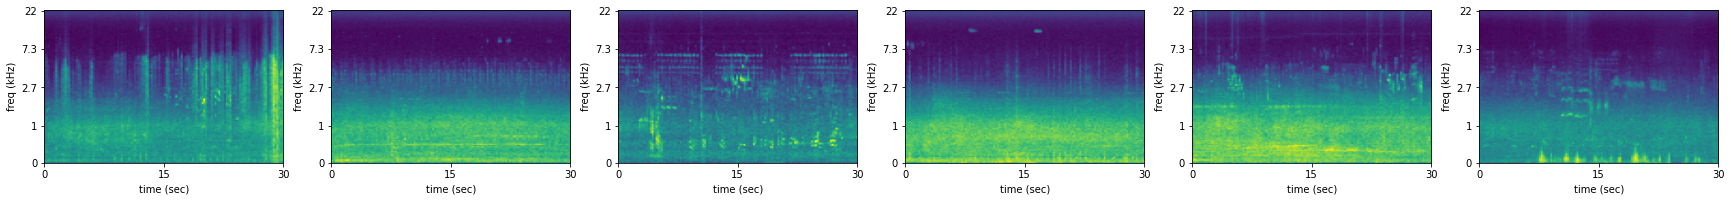

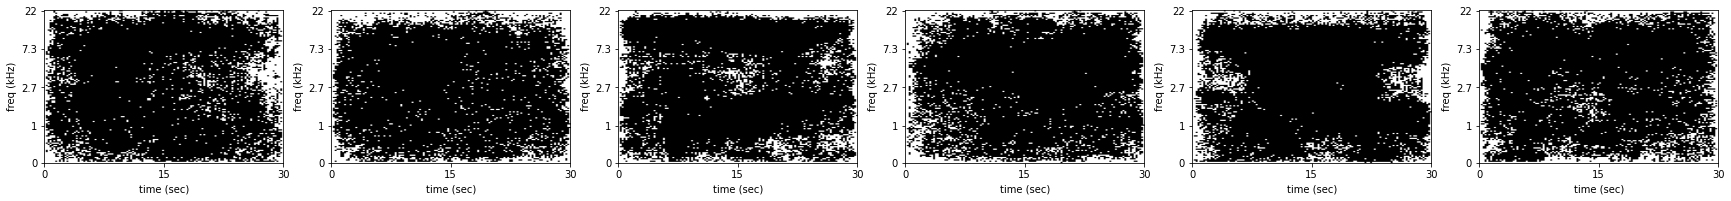

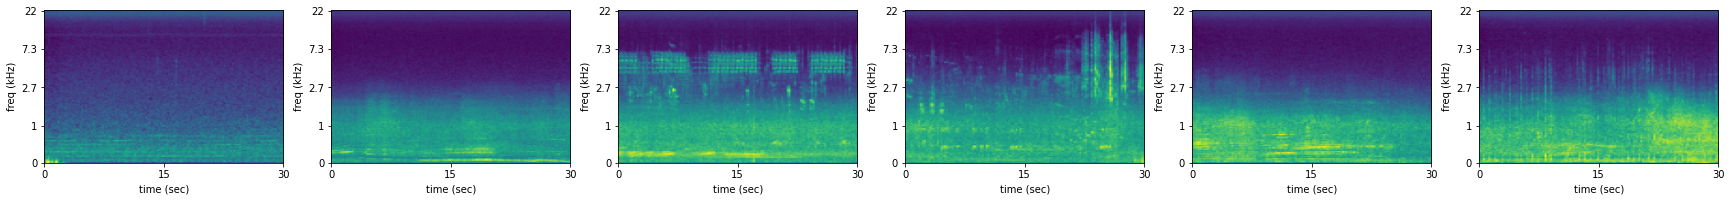

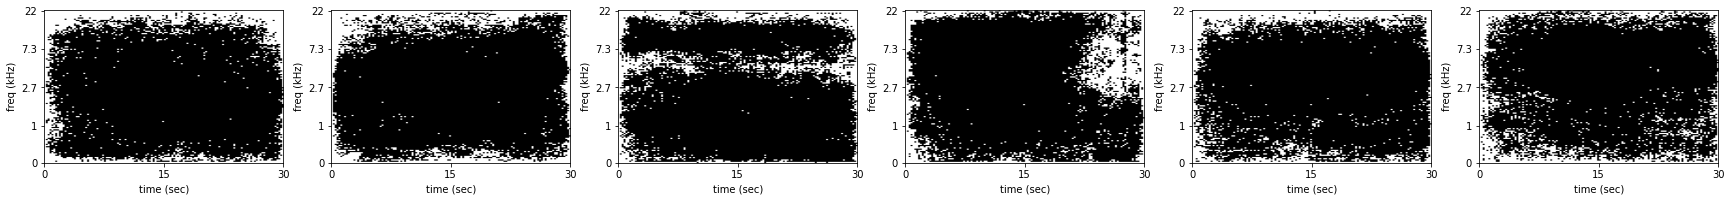

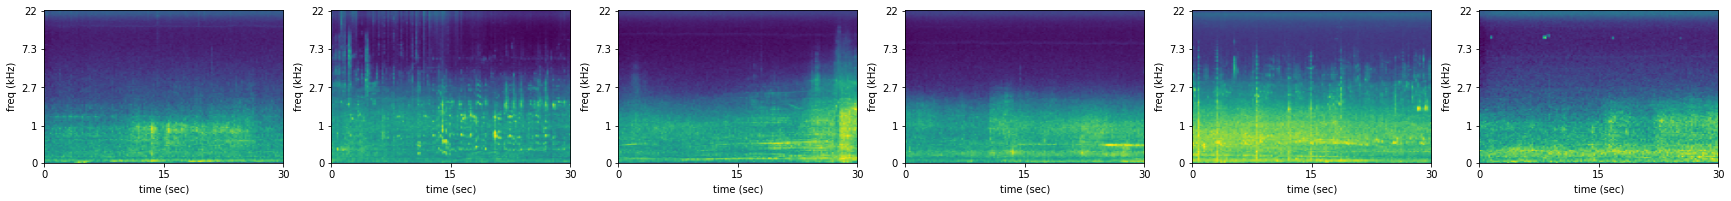

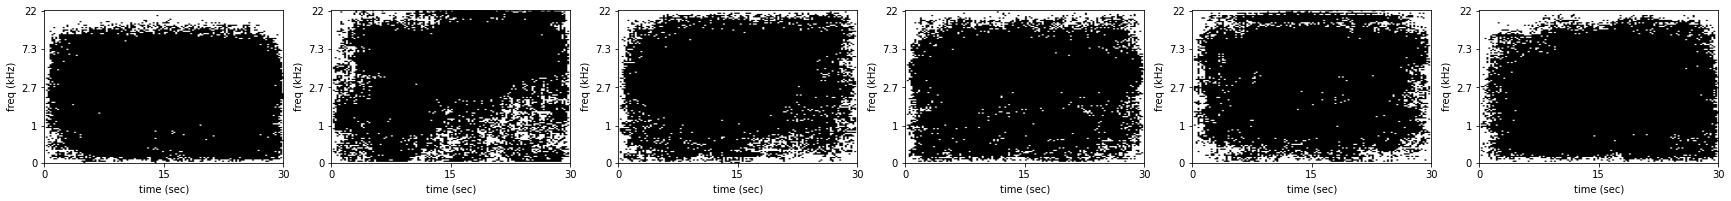

In [ ]:
%pdb off

import time
# !pip install tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable

epoch_num = 76 # take weights from this checkpoint

sigma = 0.05 # 05
grad_mag_sqr = True
num_batches = 3
num_classes = 10
n_noise_samp = 30

checkpoint_path = "/content/drive/MyDrive/project_new/copy/weights/Mono/spot_" + '_'.join(str(spot) for spot in spots_to_train)

model_name = "MonoCnnAudioNet"
model = CnnAudioNet(num_classes)
model = loadModel(model, model_name + "_" + str(epoch_num), checkpoint_path)

if(train_on_gpu): 
  model.cuda()

print("Taking weights form checkpoint no. ", epoch_num)

start_time = time.time()
#Warnings.filterwarnings('ignore')

if not time_test: 
  criterion = nn.CrossEntropyLoss()
else:
  criterion = nn.MSELoss()

model.eval()

for batch_idx, (dataBatch, target, extra_feature) in enumerate(valid_generator):
  if batch_idx >= num_batches:
    break

  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
  else:
    dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

  dataBatch = dataBatch.data.cpu().numpy()
  total_gradients = np.zeros_like(dataBatch)

  for noise_idx in tqdm(range(n_noise_samp), total=n_noise_samp, leave=False):

    # Create and add noise to dataBatch per data point
    noise = np.random.normal(0, 1, dataBatch.shape).astype(np.float32)
    for idx in range(dataBatch.shape[0]):
      data_point = dataBatch[idx, ...]
      noise[idx, ...] *= sigma * (np.max(data_point) - np.min(data_point))
    data_plus_noise = dataBatch + noise
    if train_on_gpu:
      data_plus_noise = torch.from_numpy(data_plus_noise).cuda()
    else:
      data_plus_noise = torch.from_numpy(data_plus_noise)
    data_plus_noise = Variable(data_plus_noise, requires_grad=True)

    # pass data through model
    output = model(data_plus_noise, extra_feature)

    # calculate the batch loss
    if not time_test:
      loss = criterion(output,torch.max(target.long(), 1)[1])
    else:
      loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))

    # zero input gradient before backprop
    if data_plus_noise.grad is not None:
      data_plus_noise.grad.data.zero_()

    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    input_grad = data_plus_noise.grad.data.cpu().numpy()

    if grad_mag_sqr:
      total_gradients += np.abs(input_grad)**2
    else:
      total_gradients += input_grad


  smooth_saliency_maps = total_gradients / n_noise_samp

  # plt.figure(figsize=(30, 30))
  # for i_map in range(8): # dataBatch.shape[0]):
  #     plt.subplot(8, 8, i_map + 1)
  #     spectrogram = dataBatch[i_map,...].squeeze()
  #     plt.imshow(spectrogram)
  #     plt.axis("off")
  # plt.show()

  # print('\n\n')

  # plt.figure(figsize=(30, 30))
  # for i_map in range(8): # saliency_maps.shape[0]):
  #     plt.subplot(8, 8, i_map + 1)
  #     map = smooth_saliency_maps[i_map,...].squeeze()
  #     map = (map - map.min())/(map.max() - map.min())
  #     mn_high = np.percentile(map, 30) # 30
  #     mn_low  = np.percentile(map, 5)  # 0
  #     indexes = (map<=mn_high) & (map>=mn_low)
  #     map[indexes]  = 1.0
  #     map[~indexes] = 0.0
  #     plt.imshow(np.abs(map), cmap='gray')
  #     plt.axis("off")
  # plt.show()
  
  # print('\n\n')



  plt.figure(figsize=(30, 30))
  for i_map in range(6): # dataBatch.shape[0]):
      plt.subplot(1, 6, i_map + 1)
      spectrogram = dataBatch[i_map,...].squeeze()
      plt.imshow(spectrogram, origin='lower', extent = adjusted_extent)
      # plt.axis("off")
      plt.yticks(ytick_locs,freq_ticks)
      plt.xticks(xtick_locs,time_ticks)
      plt.xlabel('time (sec)')
      plt.ylabel('freq (kHz)')
  plt.show()

  print('\n\n')

  plt.figure(figsize=(30, 30))
  for i_map in range(6): # saliency_maps.shape[0]):
      plt.subplot(1, 6, i_map + 1)
      map = smooth_saliency_maps[i_map,...].squeeze()
      map = (map - map.min())/(map.max() - map.min())
      mn_high = np.percentile(map, 20) # 30
      mn_low  = np.percentile(map, 0)  # 0
      indexes = (map<=mn_high) & (map>=mn_low)
      map[indexes]  = 1.0
      map[~indexes] = 0.0
      plt.imshow(np.abs(map), cmap='gray', origin='lower', extent = adjusted_extent)
      plt.yticks(ytick_locs,freq_ticks)
      plt.xticks(xtick_locs,time_ticks)
      plt.xlabel('time (sec)')
      plt.ylabel('freq (kHz)')
      # plt.axis("off")
  plt.show()
  
  print('\n\n')

# Guided gradient descent

required classes

In [ ]:
class GuidedBackpropGrad(object):

    def __init__(self, pretrained_model, cuda=False):
        self.pretrained_model = pretrained_model
        self.cuda = cuda
        #self.pretrained_model.eval()

    def __call__(self, input, target, criterion, extra_feature, time_test=True):
        output = self.pretrained_model(input, extra_feature)
        if not time_test:
            loss = criterion(output,torch.max(target.long(), 1)[1])
        else:
            loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))
        loss.backward(retain_graph=True)
        grad = input.grad.data.cpu().numpy()
        # grad = grad[0, :, :, :]

        return grad


class GuidedBackpropReLU(torch.autograd.Function):

    def __init__(self, inplace=False):
        super(GuidedBackpropReLU, self).__init__()
        self.inplace = inplace

    @staticmethod
    def forward(self, input):
        pos_mask = (input > 0).type_as(input)
        output = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            input,
            pos_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors

        pos_mask_1 = (input > 0).type_as(grad_output)
        pos_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            torch.addcmul(
                torch.zeros(input.size()).type_as(input), grad_output, pos_mask_1),
                pos_mask_2)

        return grad_input

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + ' (' \
            + inplace_str + ')'

class SmoothGrad(GuidedBackpropGrad):

    def __init__(self, pretrained_model, cuda=False, sigma=0.15, n_samples=25, magnitude=True):
        super(SmoothGrad, self).__init__(pretrained_model, cuda)
        """
        self.pretrained_model = pretrained_model
        self.features = pretrained_model.features
        self.cuda = cuda
        self.pretrained_model.eval()
        """
        self.sigma = sigma
        self.n_samples = n_samples
        self.magnitutde = magnitude

    def __call__(self, dataBatch, target, criterion, extra_feature, time_test=True):
        dataBatch = dataBatch.data.cpu().numpy()
        total_gradients = np.zeros_like(dataBatch)

        for noise_idx in tqdm(range(self.n_samples), total=self.n_samples, leave=False):

          # Create and add noise to dataBatch per data point
          noise = np.random.normal(0, 1, dataBatch.shape).astype(np.float32)
          for idx in range(dataBatch.shape[0]):
              data_point = dataBatch[idx, ...]
              noise[idx, ...] *= self.sigma * (np.max(data_point) - np.min(data_point))
          data_plus_noise = dataBatch + noise
          if self.cuda:
              data_plus_noise = torch.from_numpy(data_plus_noise).cuda()
          else:
              data_plus_noise = torch.from_numpy(data_plus_noise)
          data_plus_noise = Variable(data_plus_noise, requires_grad=True)

          # pass data through model
          output = self.pretrained_model(data_plus_noise, extra_feature)

          # calculate the batch loss
          if not time_test:
              loss = criterion(output,torch.max(target.long(), 1)[1])
          else:
              loss = min(criterion(output, target), criterion(output-1440, target), criterion(output+1440, target))

          # zero input gradient before backprop
          if data_plus_noise.grad is not None:
              data_plus_noise.grad.data.zero_()

          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          input_grad = data_plus_noise.grad.data.cpu().numpy()

          if self.magnitutde:
              total_gradients += np.abs(input_grad)**2
          else:
              total_gradients += input_grad

        avg_gradients = total_gradients / n_noise_samp

        return avg_gradients

In [ ]:
gbp_relu = GuidedBackpropReLU

class CnnAudioNet(nn.Module):
    def __init__(self,numClasses):
        super(CnnAudioNet,self).__init__()
        self.num_classes = numClasses
        self.fc_features = 128
        self.C1 = nn.Conv2d(1,32,3,padding=1)
        self.C11 = nn.Conv2d(32,32,3,padding=1)
        self.C2 = nn.Conv2d(32,64,3,padding=1)
        self.C22 = nn.Conv2d(64,64,3,padding=1)
        self.C3 = nn.Conv2d(64,128,3,padding=1)
        self.C33 = nn.Conv2d(128,128,3,padding=1)
        
        self.BN1 = nn.BatchNorm2d(32)
        self.BN11 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN22 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN33 = nn.BatchNorm2d(128)
        
        self.BNFC = nn.BatchNorm1d(self.fc_features)
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.maxpool2 = nn.MaxPool2d((2,2),(2,2))
        self.softmax = nn.Softmax(dim=1)
        
        self.flatten = torch.nn.Flatten()

        # self.fc1 = nn.Linear(64*32*32,self.fc_features)
        self.fc1 = nn.Linear(512,self.fc_features)
        self.fc2 = nn.Linear(self.fc_features, 1) 
        
        self.dropout = nn.Dropout(0.35)

        self.BNout = nn.BatchNorm1d(1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self,x,extra_feature):
        # add sequence of convolutional and max pooling layers
        x = self.maxpool1(gbp_relu.apply(self.BN1(self.C1(x))))
        x = self.maxpool1(gbp_relu.apply(self.BN11(self.C11(x)))) ##
        x = self.dropout(x)                                 ## @@
        x = self.maxpool1(gbp_relu.apply(self.BN2(self.C2(x))))     
        x = self.maxpool1(gbp_relu.apply(self.BN22(self.C22(x)))) ##
        x = self.maxpool1(gbp_relu.apply(self.BN3(self.C3(x))))     ## @@
        x = self.maxpool1(gbp_relu.apply(self.BN33(self.C33(x)))) ##

        x = self.flatten(x)

        x = self.BNFC(self.fc1(x))
        x = self.dropout(x)
        if not time_test:
          x = torch.cat((x, extra_feature/240), 1) #normalize extra_feature
          x = self.fc2(x)
        else:
          # x = torch.cat((x, (extra_feature-2)/100), 1) #normalize extra_feature
          x = self.fc2(x)
          x = self.BNout(x)
          x = self.sigmoid(x) * 1440
        return x

generate maps

Automatic pdb calling has been turned OFF
Starting from epoch 77


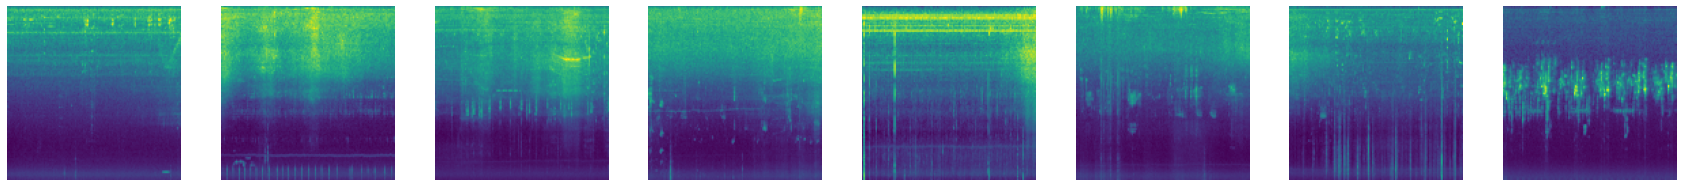

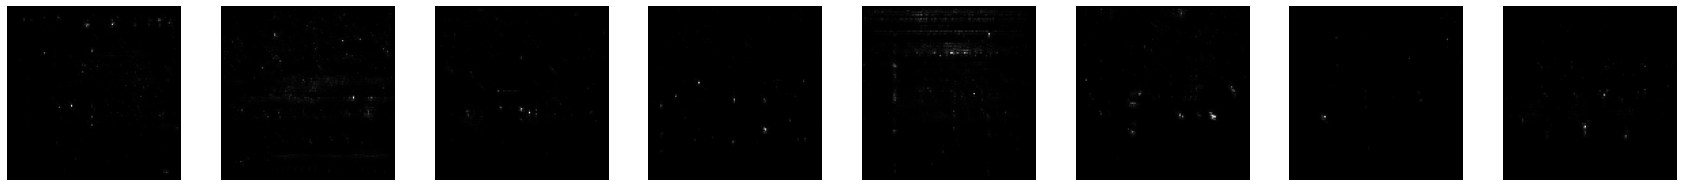

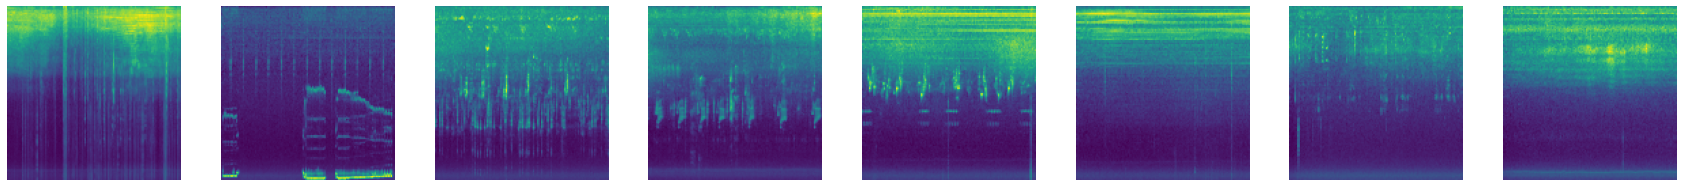

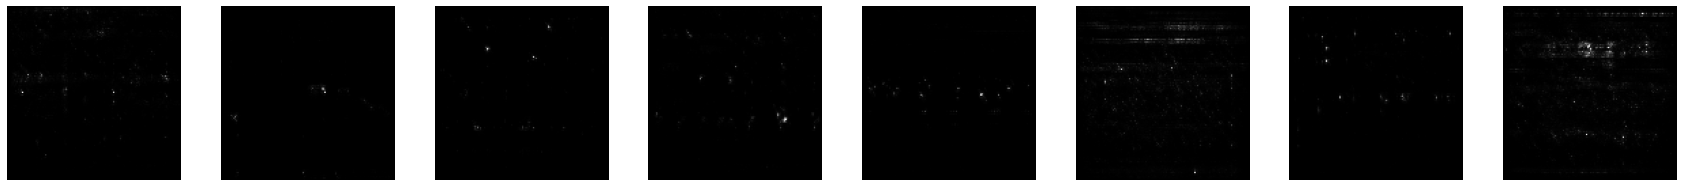

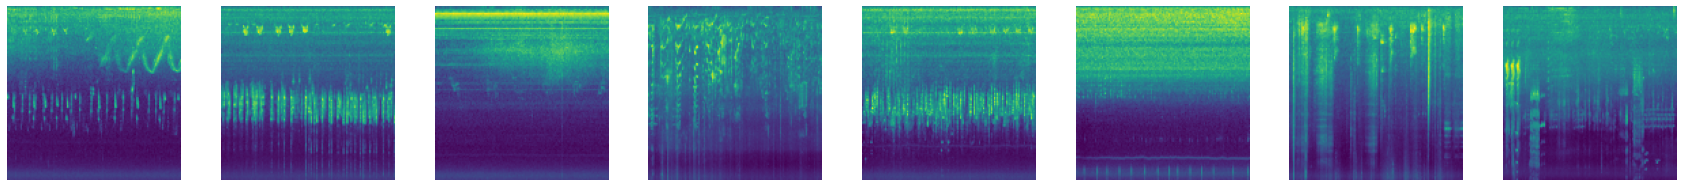

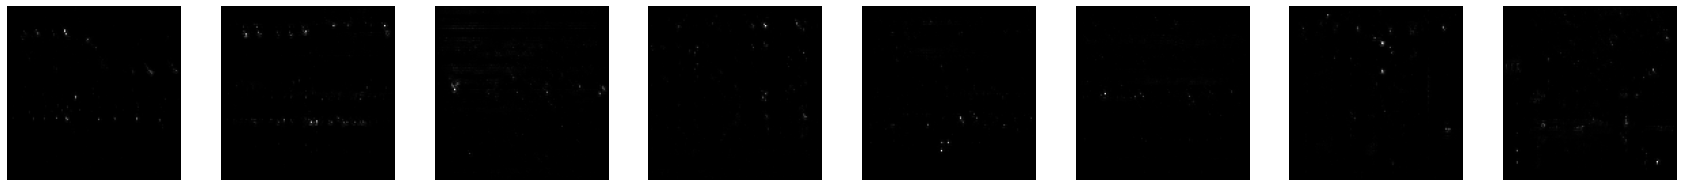

In [ ]:
%pdb off

import time
# !pip install tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, gaussian_filter, percentile_filter

epoch_num = 76 # take weights from this checkpoint
num_batches = 3

sigma = 0.05 # 05
grad_mag_sqr = True
n_noise_samp = 30


checkpoint_path = "/content/drive/MyDrive/project_new/copy/checkpoints2/time/spot_" + '_'.join(str(spot) for spot in spots_to_train)

if train_on_gpu: 
  model.cuda()

model_name = "MonoCnnAudioNet"
model = CnnAudioNet(num_classes)
model = loadModel(model, model_name + "_" + str(epoch_num), checkpoint_path)

print("Starting from epoch", epoch_num+1)

start_time = time.time()
#Warnings.filterwarnings('ignore')

if not time_test: 
  criterion = nn.CrossEntropyLoss()
else:
  criterion = nn.MSELoss()

model.eval()
guided_grad = GuidedBackpropGrad(pretrained_model=model, cuda=train_on_gpu)
smooth_guided_grad = SmoothGrad(pretrained_model=model, cuda=train_on_gpu, sigma=sigma, n_samples=n_noise_samp, magnitude=grad_mag_sqr)

for batch_idx, (dataBatch, target, extra_feature) in enumerate(valid_generator):
  if batch_idx >= num_batches:
    break

  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    dataBatch, target, extra_feature = dataBatch.unsqueeze(1).cuda(), target.cuda(), extra_feature.unsqueeze(1).cuda()#dataBatch.unsqueeze(2).float().cuda(), target.cuda()
  else:
    dataBatch, extra_feature = dataBatch.unsqueeze(1), extra_feature.unsqueeze(1)

  dataBatch.requires_grad_()

  # guided_maps = guided_grad(dataBatch, target, criterion, extra_feature)
  guided_saliency_maps = smooth_guided_grad(dataBatch, target, criterion, extra_feature)

  plt.figure(figsize=(30, 30))
  for i_map in range(8): # dataBatch.shape[0]):
      plt.subplot(8, 8, i_map + 1)
      spectrogram = dataBatch[i_map,...].squeeze().detach()
      plt.imshow(spectrogram)
      plt.axis("off")
  plt.show()

  print('\n\n')

  plt.figure(figsize=(30, 30))
  for i_map in range(8): # saliency_maps.shape[0]):
      plt.subplot(8, 8, i_map + 1)
      map = guided_saliency_maps[i_map,...].squeeze()

      # map = (map - map.min())/(map.max() - map.min())
      # mn_high = np.percentile(map, 100) # 30
      # mn_low  = np.percentile(map, 95)  # 5
      # indexes = (map<=mn_high) & (map>=mn_low)
      # map[indexes]  = 1.0
      # map[~indexes] = 0.0

      plt.imshow((np.abs(map)), cmap='gray')
      plt.axis("off")
  plt.show()
  
  print('\n\n')

# other stuff

In [ ]:
epoch_num = 5
model = loadModel(model, model_name + "_" + str(epoch_num),"/content/drive/MyDrive/project_new/copy/checkpoints1/")
model.eval()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in valid_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.unsqueeze(1).float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
  
        output = model(dataBatch,timestamp)
        outP = torch.nn.functional.softmax(output)
        
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())

accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
# import pdb; pdb.set_trace()
print('Validation accuracy: {}%'.format(accuracy * 100))

FileNotFoundError: ignored

Evaluate model on test set

In [ ]:
epoch_num = 5
model = loadModel(model, model_name + "_" + str(epoch_num),"/content/drive/MyDrive/project_new/copy/checkpoints1/")
model.eval()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in test_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.unsqueeze(1).float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
          
        output = model(dataBatch,timestamp)
        outP = torch.nn.functional.softmax(output)
        
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())

accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
print('Test accuracy: {}%'.format(accuracy * 100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Test accuracy: 38.1%


Evaluate model on training

In [ ]:
epoch_num = 5
model = loadModel(model, model_name + "_" + str(epoch_num),"/content/drive/MyDrive/project_new/copy/checkpoints1/")
model.eval()
Label_all = []
Output_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in training_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.unsqueeze(1).float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
        output = model(dataBatch, timestamp)
        outP = torch.sigmoid(output)
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())
        
accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
print('Train accuracy: {}%'.format(accuracy * 100))

Train accuracy: 94.66944444444444%


Plot confusion matrix

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).cuda()
    all_targets = torch.tensor([]).cuda()
    for batch in loader:
        images, labels, timestamp = batch
        images, labels, timestamp = images.unsqueeze(1).float().cuda(), labels.cuda(), timestamp.unsqueeze(1).cuda()#images.unsqueeze(1).float().cuda(), labels.cuda()
        preds = model(images, timestamp)
        preds = torch.nn.functional.softmax(preds)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        all_targets = torch.cat(
            (all_targets, labels)
            ,dim=0
        )
    return all_preds.cpu(), all_targets.cpu()

def confusion_matrix(real_targets, train_preds):
    stacked = torch.stack((real_targets,train_preds),dim=1)
    cmt = torch.zeros(num_classes,num_classes, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    
    return cmt


import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.type(torch.FloatTensor) / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

/home/kfir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Normalized confusion matrix


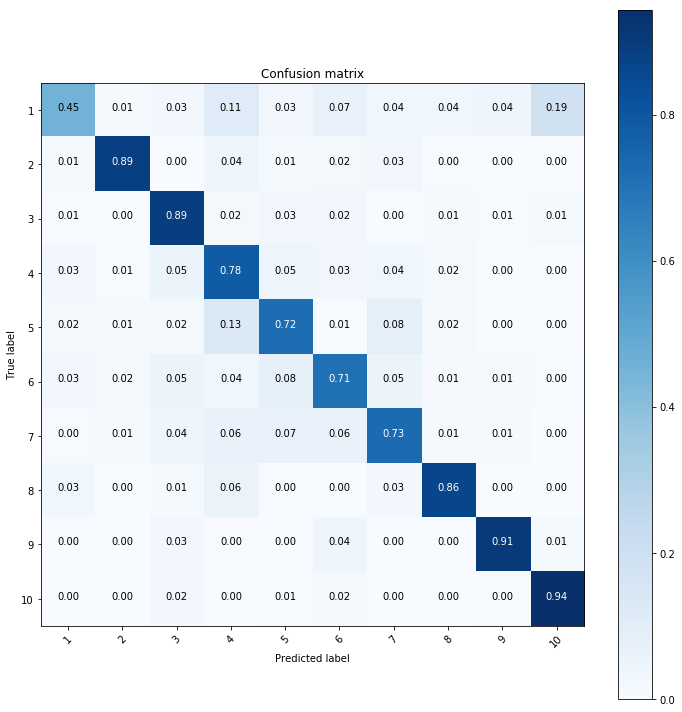

In [ ]:
import matplotlib.pyplot as plt

#from sklearn.metrics import confusion_matrix

with torch.no_grad():
    train_preds, real_targets = get_all_preds(model, test_generator)

cm = confusion_matrix(real_targets.argmax(dim=1), train_preds.argmax(dim=1))
plt.figure(figsize=(num_classes,num_classes))
classes = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
plot_confusion_matrix(cm, classes)
    

Plot accuracy throughout the day

/home/kfir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Test accuracy: 79.58275382475661%


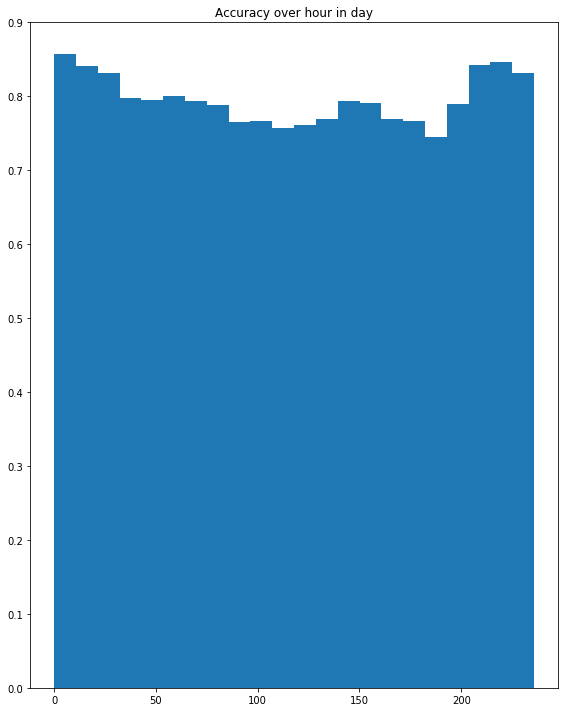

In [ ]:
epoch_num = 19
model = loadModel(model, model_name + "_" + str(epoch_num),"/media/kfir/wiseData/Project/Models/Mono/epochs/")
model.eval()
SoftM = torch.nn.Softmax()
Label_all = []
Output_all = []
timestamp_all = []
with torch.no_grad():                   # operations inside don't track history

    for dataBatch,label,timestamp in test_generator:
        if train_on_gpu:
            dataBatch,label,timestamp = dataBatch.unsqueeze(1).float().cuda(), label.cuda(), timestamp.unsqueeze(1).cuda()#dataBatch.unsqueeze(1).float().cuda(), label.cuda()
  
        output = model(dataBatch,timestamp)
        outP = torch.nn.functional.softmax(output)
        
        
        Label_all.extend(label.argmax(1).tolist())
        Output_all.extend(outP.argmax(1).tolist())
        timestamp_all.extend(timestamp.tolist())

array = (np.array(Label_all) == np.array(Output_all))
timestamp_all = np.array(timestamp_all)

plt.figure(figsize=(8, 10))
timestamp_false = timestamp_all[np.where(array==False)]
counts_false, bins_false = np.histogram(timestamp_false, bins=22)

timestamp_true = timestamp_all[np.where(array==True)]
counts_true, bins_true = np.histogram(timestamp_true, bins=22)
plt.subplot(1, 1, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.hist(bins_true[:-1], bins_true, weights=counts_true/(counts_true+counts_false))
plt.title('Accuracy over hour in day')
plt.tight_layout()

accuracy = (np.array(Label_all) == np.array(Output_all)).sum() / len(Label_all)
print('Test accuracy: {}%'.format(accuracy * 100))

Save model weights for ensemble

In [ ]:
with torch.no_grad():
    train_preds, real_targets = get_all_preds(model, valid_generator)

cm = confusion_matrix(real_targets.argmax(dim=1), train_preds.argmax(dim=1))
cm = cm.type(torch.FloatTensor) / cm.sum(axis=1)[:, np.newaxis]
model_weights = torch.zeros(10)
for i in range(0,num_classes):
    model_weights[i] = cm[i][i]
model_acc = torch.sum(model_weights) / 10

print("model accuracy is", model_acc)
print("model weights are ", model_weights)
torch.save(model_acc, "/media/kfir/wiseData/Project/Models/Mono/accuracy.pt")
torch.save(model_weights, "/media/kfir/wiseData/Project/Models/Mono/weights.pt")


/home/kfir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


model accuracy is tensor(0.9467)
model weights are  tensor([0.9234, 0.9224, 0.9600, 0.9756, 0.9563, 0.8985, 0.9626, 0.9215, 0.9630,
        0.9835])
